# 1️⃣ 🛠 Импорты и Загрузка обученной модели

Сделаем Transfer learning для определения пола, рассы и возраста по фотографии. За основу будет взята сеть `resnet50` из = https://github.com/rcmalli/keras-vggface, код оптимизируем под tf 2 и перенесём в скрипт `resnet50.py`.

## 1.1 Основные импорты и загрузка сети

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from resnet50 import RESNET50, utils

In [2]:
# последний слой классифицирует на 8631 классов
# загрузим сеть и веса
vggface_model = RESNET50()
vggface_model.summary()

2022-08-16 17:57:39.873310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 17:57:39.993657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 17:57:39.994460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 17:57:39.995974: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

165453824/165439116 [==============================] - 1s 0us/step
Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
________________

## 1.2 Сохранение модели `resnet50face.h5`

In [3]:
# h5 - сохраняет в один файл
# SavedModel - это более полный формат сохранения, который сохраняет архитектуру модели, 
# веса и отслеживаемые подграфы Tensorflow функций вызова. 
# Это позволяет Keras восстанавливать как встроенные слои, так и настраиваемые объекты.
# WARNING:tensorflow: можно не обращать внимания на эти два Warning - github 
# (в 2.3, в более позндих версиях починили их)

tf.keras.models.save_model(model=vggface_model, 
                           filepath='./models/resnet50face.h5', 
                           save_format='h5', 
                           include_optimizer=True,)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## 1.3 Проверка сохранённой модели на изображении

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на изображении.

In [4]:
!wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2022-08-16 17:57:46--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 172.67.214.206, 104.21.83.52, 2606:4700:3033::6815:5334, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|172.67.214.206|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg [following]
--2022-08-16 17:57:46--  https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.com (img.joinfo.com)... 172.67.162.235, 104.21.73.131, 2606:4700:3031::6815:4983, ...
Connecting to img.joinfo.com (img.joinfo.com)|172.67.162.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43154 (42K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  42.14K  --.-KB/s    in 0.001s  

2022-08-16 17:57:47 (69.5 MB/s) - ‘brad_pitt.jpg’ saved [43154/43154]



2022-08-16 17:57:47.848392: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-16 17:57:49.411083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1359872/1346516 [==============================] - 0s 0us/step


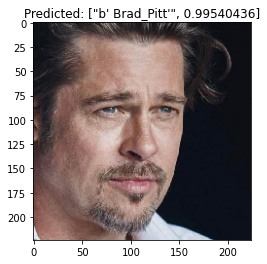

In [5]:
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2)


preds = vggface_model.predict(x)
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}")
plt.imshow(img)

# 2️⃣ 🛠 Подготовка train & val

## 2.1 Создание DataFrame

In [6]:
from pathlib import Path
from collections import Counter

data_folder = Path("../input/utkface-new/UTKFace")

filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))

# имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание
print(filenames[:3])

23708
['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg']


In [7]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)


df = df.astype({'race': 'int32', 'gender': 'int32'}) # ❗ иначе loss Nan

print('Проверка типов:', df.dtypes)

Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg
Проверка типов: img_name     object
age         float32
race          int32
gender        int32
dtype: object


In [8]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.5)

print('Тренировочная:', len(df_train))
print('Валидационная:', len(df_val))

Тренировочная: 11852
Валидационная: 11853


## 2.2 Проверка меток классов

In [9]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
    
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

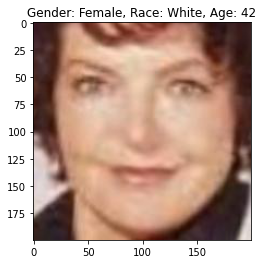

In [10]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

## 2.3 Распределение классов

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


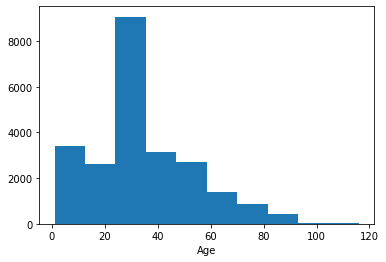

In [11]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## 2.4 Препроцессинг для изображний - генератор `image_gen`

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    return: картинка, с примененным preprocess_input(..., version=2) 
    из keras_vggface (см пример с Бредом Питом)
    """
    preprocessed = utils.preprocess_input(x=image_, version=2)
    return preprocessed

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

Found 11853 validated image filenames.
Female


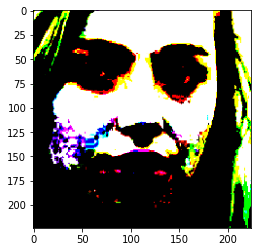

In [13]:
# Попробуем отобразить картинку и ее лейбл для проверки генерации:
# мы получим очень странное изображение и это нормально. 
# matplotlib ожидает картинку с интесивностями от 0 до 1 если она типа float и от 0 до 255 если int.
IMAGE_SIZE = (224, 224)
CLASS_MODE = 'raw'
BATCH_SIZE = 128

val_generator = image_gen.flow_from_dataframe(dataframe=df_val,
                                              directory=data_folder,
                                              x_col='img_name',
                                              y_col='gender', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              target_size=IMAGE_SIZE)

sample_images, sample_labels = next(val_generator)

plt.imshow(sample_images[100])
print(gender_mapping[int(sample_labels[100])])

In [14]:
# можно увидеть что значения яркостей типа float и в т.ч. отрицательные
print(sample_images[100].max(), sample_images[100].min())

147.5047 -118.0912


Male


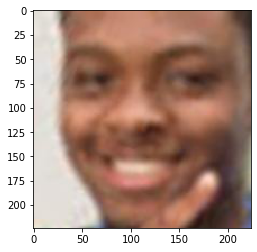

In [15]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """

    x_temp = np.copy(vggface_image)

    x_temp[..., 2] += 131.0912
    x_temp[..., 1] += 103.8827
    x_temp[..., 0] += 91.4953
    x_temp = x_temp[..., ::-1]


    image = x_temp.astype(np.uint8)

    return image

# теперь картинка должна отображаться корректно
plt.imshow(deprocess_image(sample_images[5]))

print(gender_mapping[int(sample_labels[5])])

# 3️⃣🚻✅ Модель определения пола

In [16]:
# Визуализация предсказаний
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

## 3.1 Генератор train & val - `image_gen.flow_from_dataframe`

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128

# ✔ В 2.3 - target_size (в 1.4), изменён на List
# ❗ Данная константа серьёзно влияет на другой код int -> tuple
IMAGE_SIZE = (224, 224)
CLASS_MODE = 'raw'


train_generator = image_gen.flow_from_dataframe(dataframe=df_train, 
                                                directory=data_folder, 
                                                x_col='img_name', 
                                                y_col='gender', 
                                                class_mode=CLASS_MODE,
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True, 
                                                target_size=IMAGE_SIZE)


val_generator = image_gen.flow_from_dataframe(dataframe=df_val,
                                              directory=data_folder,
                                              x_col='img_name',
                                              y_col='gender', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              target_size=IMAGE_SIZE)

Found 11852 validated image filenames.
Found 11853 validated image filenames.


## 3.2 Архитектура модели, заморозка

In [18]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

# ❗Загрузить модель с диска
# vggface_model = load_model("./models/resnet50face.h5")

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer(index=-2).output)

vggface_model.summary()

# замораживаем всю базовую модель, не дал лучший результат.
# разморозка последнего слоя (8k параметров), приводит к 17M парметров на обучении.
# Обойдёмся дополнительным полносвязным слоем на 64 нейрона
base_model.trainable = False

print("weights:", len(base_model.weights))
print("trainable_weights:", len(base_model.trainable_weights))
print("non_trainable_weights:", len(base_model.non_trainable_weights))

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [19]:
# Модели можно исопользовать как слои
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 23,692,353
Trainable params: 131,201
Non-trainable params: 23,561,152
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## 3.3 Callbacks

In [20]:
from pathlib import Path
path = Path("./models")
path.mkdir(exist_ok=True)


cpt_path = "./models/gender_checkpoint_best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, 
                                                monitor='val_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')


import datetime
log_dir = '../tblogs/gender_model_' + datetime.datetime.now().strftime('%y-%m-%d_%H-%M')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2022-08-16 17:59:04.130865: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-16 17:59:04.130905: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-16 17:59:04.133220: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-08-16 17:59:04.573818: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-16 17:59:04.574028: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


## 3.4 Обучение

In [21]:
EPOCHS = 15

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=25,
    callbacks=[tensorboard_callback, checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/15
 1/25 [>.............................] - ETA: 1:40 - loss: 0.7940 - accuracy: 0.5469

2022-08-16 17:59:10.143534: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-16 17:59:10.143577: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/25 [=>............................] - ETA: 14s - loss: 0.7600 - accuracy: 0.5547 

2022-08-16 17:59:10.692576: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-16 17:59:10.694399: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-08-16 17:59:10.837463: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 392 callback api events and 389 activity events. 
2022-08-16 17:59:10.853348: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-16 17:59:10.878487: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tblogs/gender_model_22-08-16_17-59/train/plugins/profile/2022_08_16_17_59_10

2022-08-16 17:59:10.890451: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tblogs/gender_model_22-08-16_17-59/train/plugins/profile/2022_08_16_17_59_10/25d001795c2d.trace.json.gz
2022-08-16 17:59:10.941078: I tensorflow/core/profiler/r

25/25 [==============================] - 126s 5s/step - loss: 0.4425 - accuracy: 0.7850 - val_loss: 0.2529 - val_accuracy: 0.9101

Epoch 00001: val_accuracy improved from -inf to 0.91006, saving model to ./models/gender_checkpoint_best.hdf5
Epoch 2/15
25/25 [==============================] - 65s 3s/step - loss: 0.1926 - accuracy: 0.9334 - val_loss: 0.1850 - val_accuracy: 0.9319

Epoch 00002: val_accuracy improved from 0.91006 to 0.93192, saving model to ./models/gender_checkpoint_best.hdf5
Epoch 3/15
25/25 [==============================] - 62s 3s/step - loss: 0.1629 - accuracy: 0.9397 - val_loss: 0.1763 - val_accuracy: 0.9321

Epoch 00003: val_accuracy improved from 0.93192 to 0.93208, saving model to ./models/gender_checkpoint_best.hdf5
Epoch 4/15
25/25 [==============================] - 59s 2s/step - loss: 0.1401 - accuracy: 0.9508 - val_loss: 0.1667 - val_accuracy: 0.9376

Epoch 00004: val_accuracy improved from 0.93208 to 0.93757, saving model to ./models/gender_checkpoint_best.hd

## 3.5 Валидация полученной модели

In [22]:
from tensorflow.keras.models import load_model

model_gender = load_model("./models/gender_checkpoint_best.hdf5")

loss, acc = model_gender.evaluate(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

93/93 [==============================] - 44s 463ms/step - loss: 0.1532 - accuracy: 0.9424
Well done!


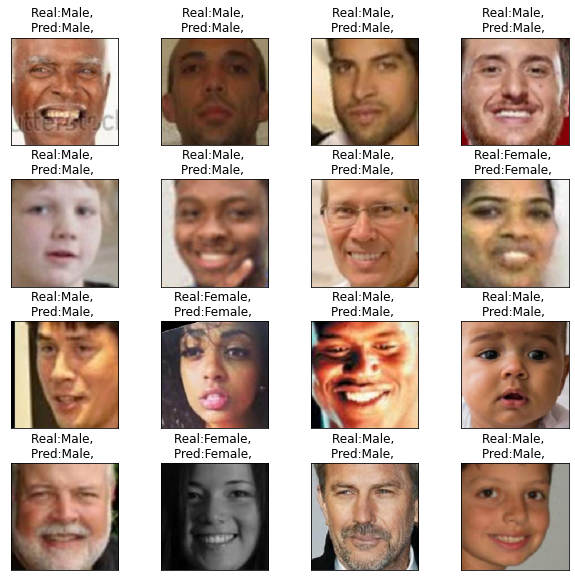

In [23]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

# 4️⃣🔠✅ Модель предсказания расы

In [24]:
# если используем сохранённую модель
# vggface_model = load_model("./models/resnet50face.h5")

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer(index=-2).output)

base_model.trainable = False

## 4.1 Генератеры - раса

In [25]:
IMAGE_SIZE = (224, 224)
CLASS_MODE = 'raw'

train_generator = image_gen.flow_from_dataframe(dataframe=df_train, 
                                                directory=data_folder, 
                                                x_col='img_name', 
                                                y_col='race', 
                                                class_mode=CLASS_MODE,
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True, 
                                                target_size=IMAGE_SIZE)



val_generator = image_gen.flow_from_dataframe(dataframe=df_val, 
                                              directory=data_folder, 
                                              x_col='img_name', 
                                              y_col='race', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              target_size=IMAGE_SIZE
)

# "sparse": 1D numpy array of integer labels

Found 11852 validated image filenames.
Found 11853 validated image filenames.


## 4.2 Архитектура

In [26]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(5, activation='softmax') # ❗5 рас в наборе
])


scce = tf.keras.losses.SparseCategoricalCrossentropy()
m = tf.keras.metrics.SparseCategoricalAccuracy()


model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=scce,
              metrics=[m])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2048)              23561152  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 24,127,173
Trainable params: 566,021
Non-trainable params: 23,561,152
_________________________________________________________________


## 4.3 Callbacks

In [27]:
from pathlib import Path
path = Path("./models")
path.mkdir(exist_ok=True)


cpt_path = "./models/race_checkpoint_best.h5"


checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, 
                                                monitor='val_sparse_categorical_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

import datetime
log_dir = '../tblogs/race_model_' + datetime.datetime.now().strftime('%y-%m-%d_%H-%M')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

log_dir

2022-08-16 18:19:43.933682: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-16 18:19:43.933738: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-16 18:19:44.170890: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-16 18:19:44.171075: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


'../tblogs/race_model_22-08-16_18-19'

## 4.4 Обучение

In [28]:
EPOCHS = 15

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=25,
    callbacks=[tensorboard_callback, checkpoint])

Epoch 1/15
 1/25 [>.............................] - ETA: 1:13 - loss: 1.6065 - sparse_categorical_accuracy: 0.1953

2022-08-16 18:19:48.091637: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-16 18:19:48.091813: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/25 [=>............................] - ETA: 14s - loss: 1.5665 - sparse_categorical_accuracy: 0.2852 

2022-08-16 18:19:49.082056: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-16 18:19:49.084104: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-08-16 18:19:49.233670: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 393 callback api events and 390 activity events. 
2022-08-16 18:19:49.253700: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-16 18:19:49.277925: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tblogs/race_model_22-08-16_18-19/train/plugins/profile/2022_08_16_18_19_49

2022-08-16 18:19:49.292625: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tblogs/race_model_22-08-16_18-19/train/plugins/profile/2022_08_16_18_19_49/25d001795c2d.trace.json.gz
2022-08-16 18:19:49.381999: I tensorflow/core/profiler/rpc/c

25/25 [==============================] - 59s 2s/step - loss: 1.2269 - sparse_categorical_accuracy: 0.5213 - val_loss: 0.8765 - val_sparse_categorical_accuracy: 0.8323

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.83228, saving model to ./models/race_checkpoint_best.h5
Epoch 2/15
25/25 [==============================] - 53s 2s/step - loss: 0.6538 - sparse_categorical_accuracy: 0.8594 - val_loss: 0.5362 - val_sparse_categorical_accuracy: 0.8607

Epoch 00002: val_sparse_categorical_accuracy improved from 0.83228 to 0.86071, saving model to ./models/race_checkpoint_best.h5
Epoch 3/15
25/25 [==============================] - 55s 2s/step - loss: 0.4604 - sparse_categorical_accuracy: 0.8737 - val_loss: 0.4416 - val_sparse_categorical_accuracy: 0.8686

Epoch 00003: val_sparse_categorical_accuracy improved from 0.86071 to 0.86864, saving model to ./models/race_checkpoint_best.h5
Epoch 4/15
25/25 [==============================] - 55s 2s/step - loss: 0.3879 - sparse_categ

In [29]:
model_race = load_model("./models/race_checkpoint_best.h5")
loss, acc = model_race.evaluate(val_generator)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

93/93 [==============================] - 55s 576ms/step - loss: 0.3814 - sparse_categorical_accuracy: 0.8802
Well done!


## 4.5 Валидация полученной модели

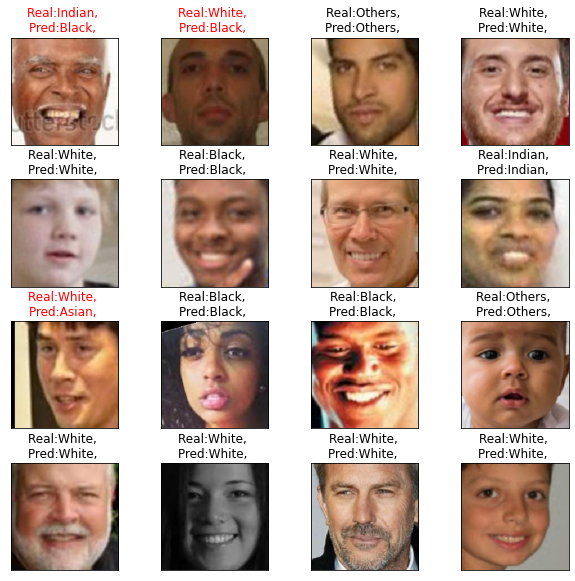

In [30]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

# 5️⃣🚻🔠🔢✅ Multitask learning

## 5.1 Три головы

In [31]:
# vggface_model = load_model("./models/resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer(index=-1).output)
base_model.trainable = False

## 5.2 Архитектура

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 8631)         41246071    input_2[0][0]                    
__________________________________________________________________________________________________
added_new_layer (Dense)         (None, 64)           552448      model_2[0][0]                    
__________________________________________________________________________________________________
gender (Dense)                  (None, 1)            65          added_new_layer[0][0]            
____________________________________________________________________________________________

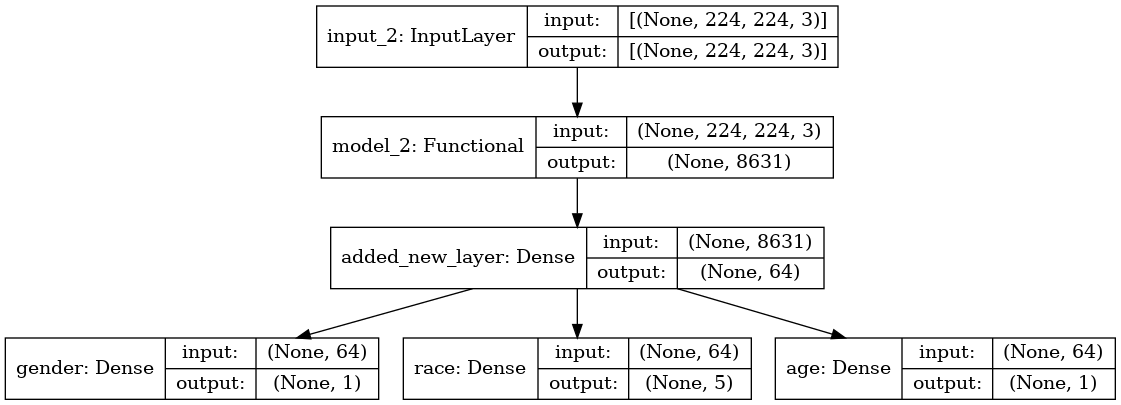

In [32]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

SHAPE = (224, 224, 3)


# Входной слой
input_layer = Input(shape=SHAPE)

# Базовая модель, загружена и заморожена
base_model_main = base_model(input_layer)

out_base = Dense(64, name='added_new_layer')(base_model_main)


# Три выхода
race_output = Dense(5, activation='softmax', name='race')(out_base)
age_output = Dense(1, activation='sigmoid', name='age')(out_base)
gender_output = Dense(1, activation='sigmoid', name='gender')(out_base)

outputs=[gender_output, race_output, age_output]

# Сбор модели
model = tf.keras.Model(inputs=input_layer, outputs=outputs)

model.summary()

plot_model(model, show_shapes=True)

In [33]:
# вы можете выбрать другую скорость обучения для вашей модели
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# обратите внимание, что теперь loss -- это словарь, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics

# ❗ так надёжнее, чтобы при компиляции, нужные модули попали в модель
loss_bc = tf.keras.losses.BinaryCrossentropy()
loss_scce = tf.keras.losses.SparseCategoricalCrossentropy()
loss_mse = tf.keras.losses.MeanSquaredError()


metric_bc = tf.keras.metrics.BinaryAccuracy()
metric_scce = tf.keras.metrics.SparseCategoricalAccuracy()
metric_mae = tf.keras.metrics.MeanAbsoluteError()

model.compile(optimizer=optimizer, 
              loss={'gender': loss_bc, 'race': loss_scce, 'age': loss_mse},
              metrics={'gender': metric_bc, 'race': metric_scce, 'age': metric_mae})

## 5.3 Генератеры

In [34]:
CLASS_MODE = 'multi_output' # multi_output
TARGET_SIZE = IMAGE_SIZE

train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode=CLASS_MODE,
        x_col="img_name", y_col=["gender", "race", "age"],
        directory=str(data_folder),
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True)


val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode=CLASS_MODE,
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True)

Found 11852 validated image filenames.
Found 11853 validated image filenames.


## 5.4 Callbacks

In [35]:
path = Path("./models")
path.mkdir(exist_ok=True)
cpt_filename = "./models/multitask_checkpoint_best.h5"


checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_filename, 
                                                monitor='val_age_mean_absolute_error', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')

# tensorboard - названия для экспериментов
import datetime
log_dir = '../tblogs/multitask_three_out_' + datetime.datetime.now().strftime('%y-%m-%d_%H-%M')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

log_dir

2022-08-16 18:38:19.307175: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-16 18:38:19.308448: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-16 18:38:19.722079: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-16 18:38:19.722289: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


'../tblogs/multitask_three_out_22-08-16_18-38'

## 5.5 Обучение

In [36]:
EPOCHS = 15

model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator,
          callbacks=[tensorboard_callback, checkpoint], steps_per_epoch=50, 
          validation_steps=len(df_val) // BATCH_SIZE)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/15
 1/50 [..............................] - ETA: 3:25 - loss: 2.3810 - gender_loss: 0.6931 - race_loss: 1.6087 - age_loss: 0.0791 - gender_binary_accuracy: 0.4844 - race_sparse_categorical_accuracy: 0.1875 - age_mean_absolute_error: 0.2448

2022-08-16 18:38:25.315398: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-16 18:38:25.316240: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/50 [>.............................] - ETA: 28s - loss: 2.3779 - gender_loss: 0.6930 - race_loss: 1.6066 - age_loss: 0.0783 - gender_binary_accuracy: 0.5049 - race_sparse_categorical_accuracy: 0.3137 - age_mean_absolute_error: 0.2432 

2022-08-16 18:38:26.374272: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-16 18:38:26.379108: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-08-16 18:38:26.542556: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 461 callback api events and 453 activity events. 
2022-08-16 18:38:26.568496: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-16 18:38:26.604041: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tblogs/multitask_three_out_22-08-16_18-38/train/plugins/profile/2022_08_16_18_38_26

2022-08-16 18:38:26.621076: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tblogs/multitask_three_out_22-08-16_18-38/train/plugins/profile/2022_08_16_18_38_26/25d001795c2d.trace.json.gz
2022-08-16 18:38:26.720550: I tensorflow/c

50/50 [==============================] - 89s 2s/step - loss: 2.2221 - gender_loss: 0.6771 - race_loss: 1.4847 - age_loss: 0.0602 - gender_binary_accuracy: 0.6359 - race_sparse_categorical_accuracy: 0.4170 - age_mean_absolute_error: 0.2131 - val_loss: 2.0561 - val_gender_loss: 0.6599 - val_race_loss: 1.3525 - val_age_loss: 0.0437 - val_gender_binary_accuracy: 0.6478 - val_race_sparse_categorical_accuracy: 0.4280 - val_age_mean_absolute_error: 0.1792

Epoch 00001: val_age_mean_absolute_error improved from inf to 0.17920, saving model to ./models/multitask_checkpoint_best.h5
Epoch 2/15
50/50 [==============================] - 84s 2s/step - loss: 1.9304 - gender_loss: 0.6421 - race_loss: 1.2535 - age_loss: 0.0349 - gender_binary_accuracy: 0.7748 - race_sparse_categorical_accuracy: 0.4269 - age_mean_absolute_error: 0.1555 - val_loss: 1.8002 - val_gender_loss: 0.6171 - val_race_loss: 1.1524 - val_age_loss: 0.0308 - val_gender_binary_accuracy: 0.8443 - val_race_sparse_categorical_accuracy: 0.

## 5.6 Валидация полученной модели

In [37]:
model_multitask = load_model("./models/multitask_checkpoint_best.h5")
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode=CLASS_MODE,
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True)


results = model.evaluate(val_generator, steps=len(df_val)//BATCH_SIZE)

assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

Found 11853 validated image filenames.
92/92 [==============================] - 47s 508ms/step - loss: 0.6386 - gender_loss: 0.1872 - race_loss: 0.4413 - age_loss: 0.0100 - gender_binary_accuracy: 0.9265 - race_sparse_categorical_accuracy: 0.8600 - age_mean_absolute_error: 0.0766
Well done!


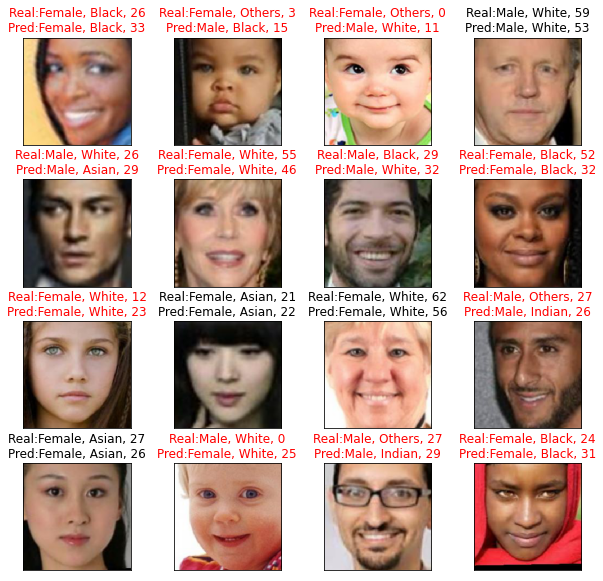

In [38]:
# sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
sample_validation_images, sample_validation_labels = next(val_generator)


predicted = model_multitask.predict(sample_validation_images)

show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

# 📷✅ Как работает сеть

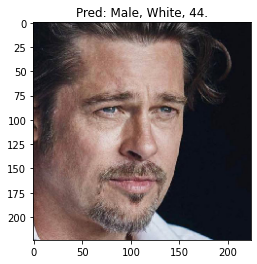

In [39]:
OUTPUT = './brad_pitt.jpg'

img = image.load_img(OUTPUT, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)

gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]

title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."

_ = plt.title(title_obj)